In [1]:
import sys
sys.path.append('../../')
from localconfig import BASE_PATH,EXPS

import pathlib
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate
np.set_printoptions(threshold=1050)
from pprint import pprint

import maxone_code.data
import maxone_code.fig
from maxone_code.data import Experiment
from maxone_code.artifact.remover import ArtifactAssay

In [2]:
from maxone_code.spikedetect import BandPassFilter,HighPassFilter

bpfs = {
    'BPF1000': BandPassFilter(lowcut=250, highcut=1000, order=4),
    'BPF2000': BandPassFilter(lowcut=250, highcut=2000, order=4),
    'BPF3000': BandPassFilter(lowcut=250, highcut=3000, order=4),
    'BPF4000': BandPassFilter(lowcut=250, highcut=4000, order=4),
    'BPF5000': BandPassFilter(lowcut=250, highcut=5000, order=4),
    'BPF7500': BandPassFilter(lowcut=250, highcut=7500, order=4),
    'BPF9000': BandPassFilter(lowcut=250, highcut=9000, order=4),
    'HPF': HighPassFilter(lowcut=250,order=4),
    }

In [3]:
EXP=EXPS[1]
dirpath=pathlib.Path(BASE_PATH).joinpath('data',EXP,'raw')
FILES=[p.name for p in list(dirpath.iterdir()) if str(p).endswith('h5')]
FILE=FILES[0]
path=pathlib.Path(BASE_PATH).joinpath('data',EXP,'raw',FILE)
print(EXP,FILE)
pprint(FILES)

takahashi1115dac40 searching-5835-5834.raw.h5
['searching-5835-5834.raw.h5',
 'searching-5835-5835.raw.h5',
 'searching-5835-5836.raw.h5',
 'searching-5835-6055.raw.h5',
 'searching-9295-9294.raw.h5',
 'searching-9295-9295.raw.h5',
 'searching-9295-9515.raw.h5',
 'searching-984-983.raw.h5',
 'searching-984-984.raw.h5',
 'searching-984-985.raw.h5']


### サチュレーション
- trial一回目はすべて1023bitでサチる
- ほとんどの場合で0bitでサチる

In [4]:
assay_list={}
assay_maxsati=None
maxsati=-1
for i,file in enumerate(FILES):
    path=pathlib.Path(BASE_PATH).joinpath('data',EXP,'raw',file)
    assay=ArtifactAssay(path,lookforframe=1000)
    # 刺激開始フレームの表示
    assay.loaddata()
    indices=np.where(assay.data_raw==1023)[0]
    if len(indices)==0:
        print('no saturation')
        assay_list[file]=assay
    elif np.max(indices) == 0:
        print('ok')
#         assay.exp.disp()
        assay_list[file]=assay
    else:
        if len(indices) > maxsati:
            assay_maxsati = assay
            maxsati=len(indices) 
pprint(list(assay_list.keys()))

ok
ok
ok
ok
['searching-5835-5834.raw.h5',
 'searching-5835-5836.raw.h5',
 'searching-9295-9515.raw.h5',
 'searching-984-983.raw.h5']


In [5]:
for file,assay in assay_list.items():
    indices=np.where(assay.data_raw==0)[0]
    print(file)
    print(indices)

searching-5835-5834.raw.h5
[0 0 0 0 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4 4]
searching-5835-5836.raw.h5
[0 0 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4 4 4 4 4]
searching-9295-9515.raw.h5
[0 1 4]
searching-984-983.raw.h5
[0 1 1 1 2 2 2 3 3 3 4 4 4]


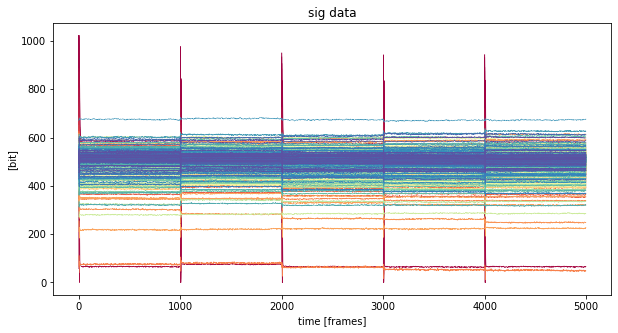

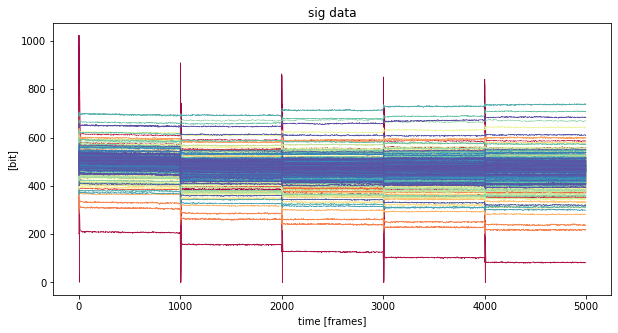

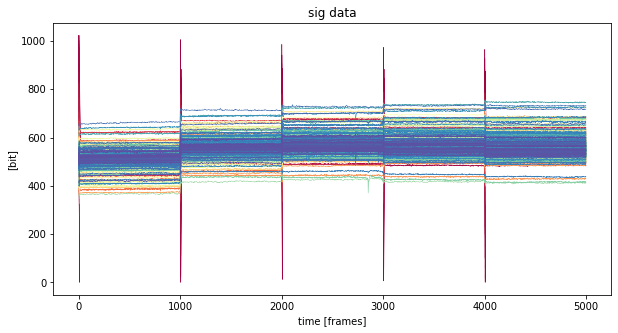

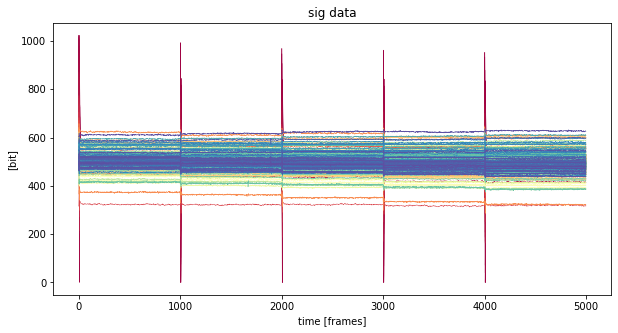

In [6]:
for assay in assay_list.values():
    assay.disp_raw()

### サチったデータを除くとモデルに合ったアーチファクトが見れる
- assay=assay_list['searching-9295-9515.raw.h5']
- のデータがきれいそう


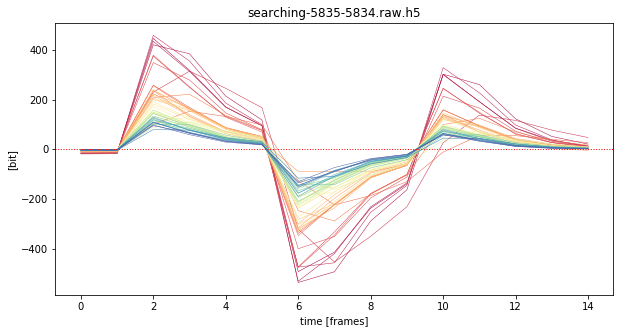

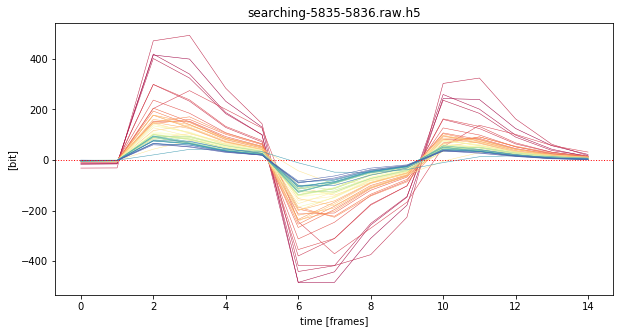

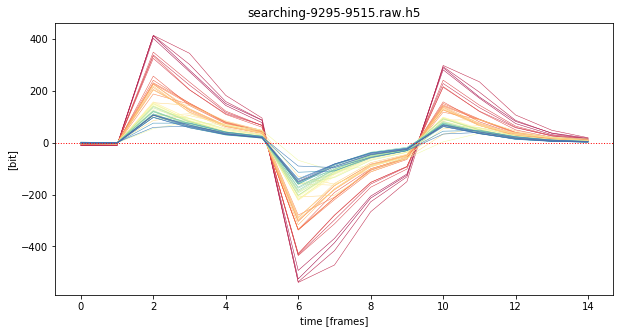

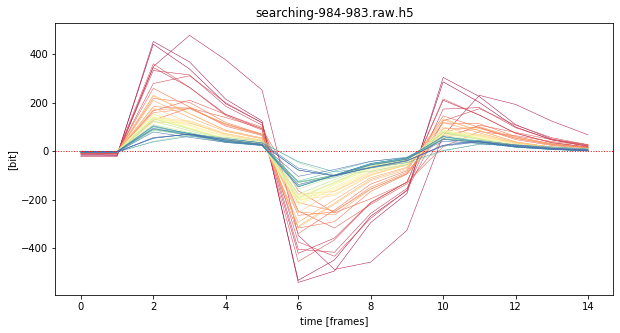

In [7]:
for file,assay in assay_list.items():
    bpf=bpfs['HPF']
    assay.data_filtered_m=assay.filterProccessing(bpf,assay.data_raw_m, True)
    assay.data_filtered=assay.data_filtered_m[:, :, assay.BPF_MARGIN_FRAME:-assay.BPF_MARGIN_FRAME]
    assay.disp_filtered(trange=[1],yrange=None,xids=np.s_[0:50], frange=np.s_[:15], title=file)
    

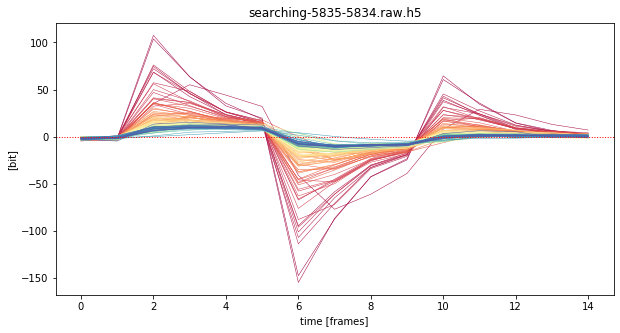

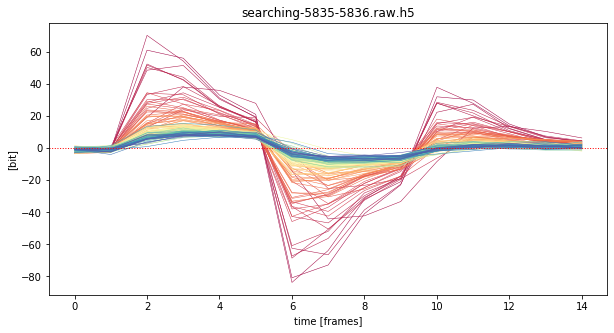

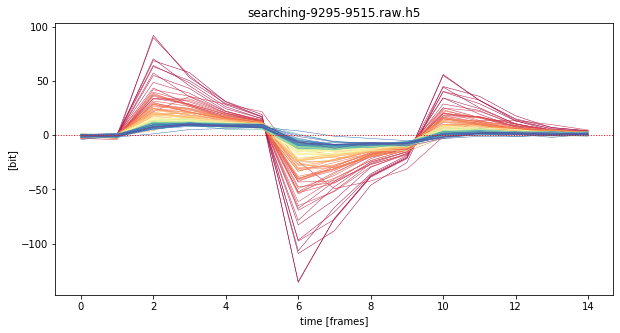

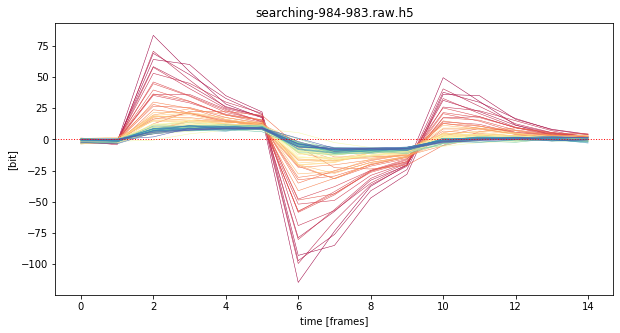

In [8]:
# 遠い電極でも比例関係が見れる
for file,assay in assay_list.items():
    bpf=bpfs['HPF']
    assay.data_filtered_m=assay.filterProccessing(bpf,assay.data_raw_m, True)
    assay.data_filtered=assay.data_filtered_m[:, :, assay.BPF_MARGIN_FRAME:-assay.BPF_MARGIN_FRAME]
    assay.disp_filtered(trange=[1],yrange=None,xids=np.s_[50::5], frange=np.s_[:15], title=file)
    

### フィルタが変わるとアーチファクトの形も変わる
- 1000,2000は波形が大きく変わる

In [9]:
list(assay_list.items())

[('searching-5835-5834.raw.h5',
  <maxone_code.artifact.remover.ArtifactAssay at 0x122c4cf50>),
 ('searching-5835-5836.raw.h5',
  <maxone_code.artifact.remover.ArtifactAssay at 0x122e5f110>),
 ('searching-9295-9515.raw.h5',
  <maxone_code.artifact.remover.ArtifactAssay at 0x122c520d0>),
 ('searching-984-983.raw.h5',
  <maxone_code.artifact.remover.ArtifactAssay at 0x122e71910>)]

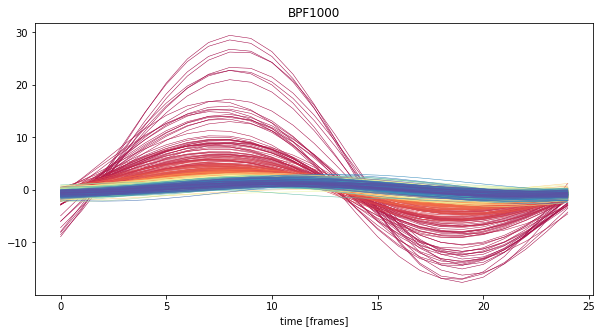

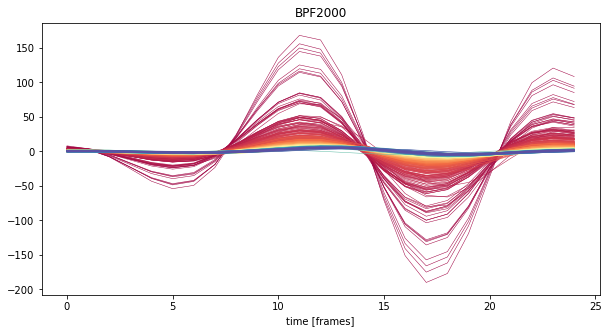

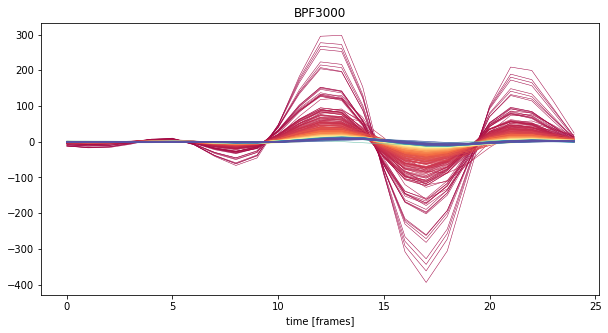

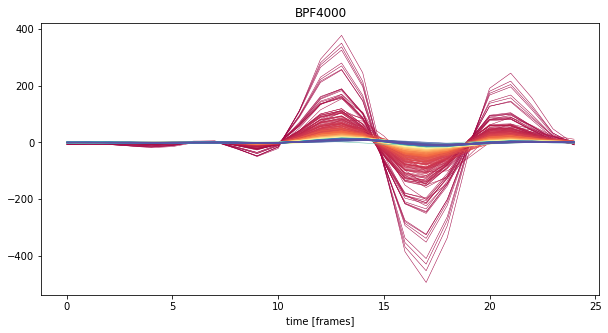

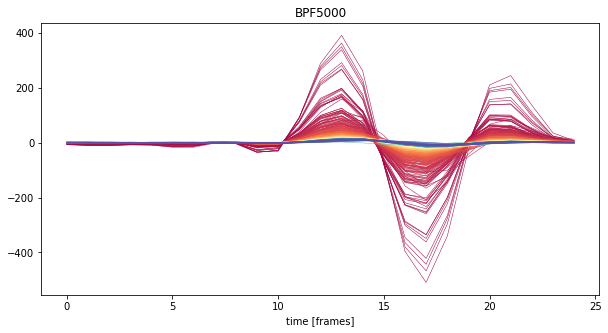

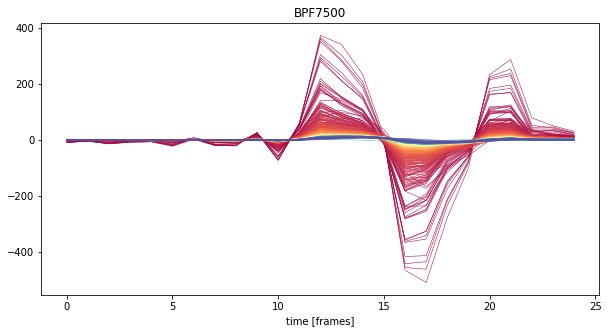

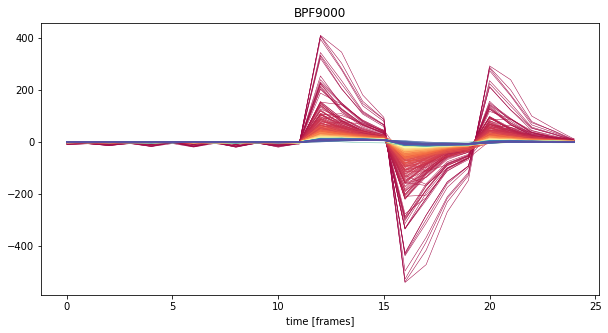

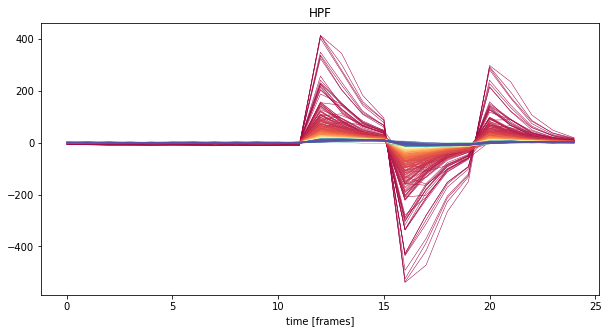

In [14]:
for name,bpf in bpfs.items():
    assay=assay_list['searching-9295-9515.raw.h5']
    assay.data_filtered_m=assay.filterProccessing(bpf,assay.data_raw_m, True)
    assay.data_filtered=assay.data_filtered_m[:, :, assay.BPF_MARGIN_FRAME:-assay.BPF_MARGIN_FRAME]
#     assay.disp_filtered(trange=[1],yrange=None,xids=None, frange=np.s_[:15], title=name)
    assay.disp_data(assay.data_filtered_m,trange=1, frange=np.s_[290:315], title=name)

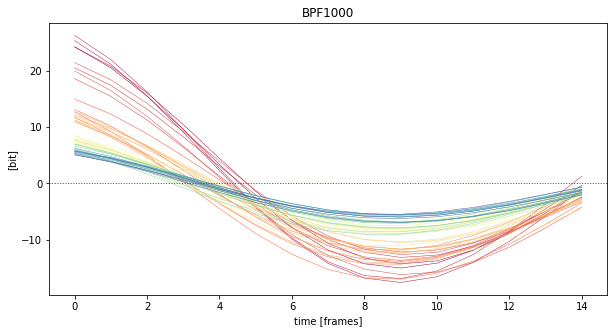

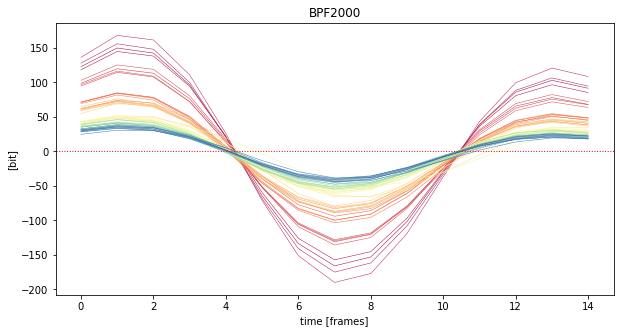

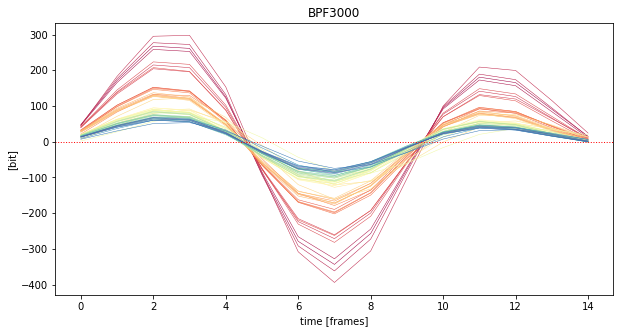

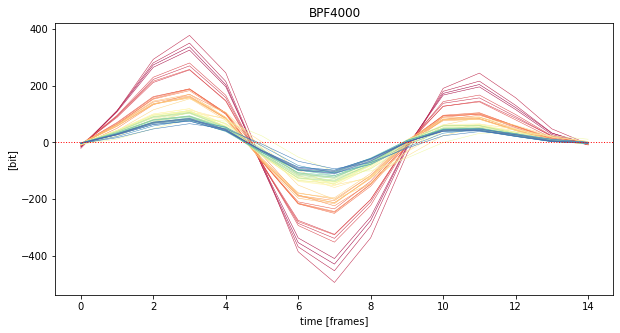

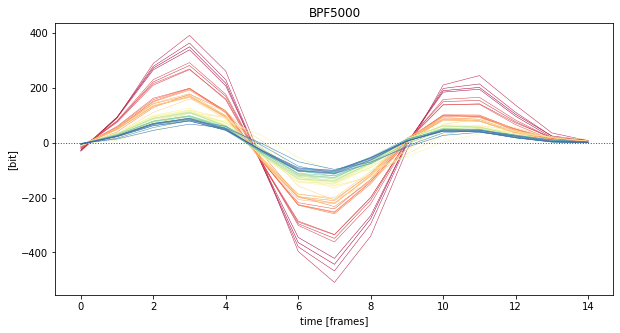

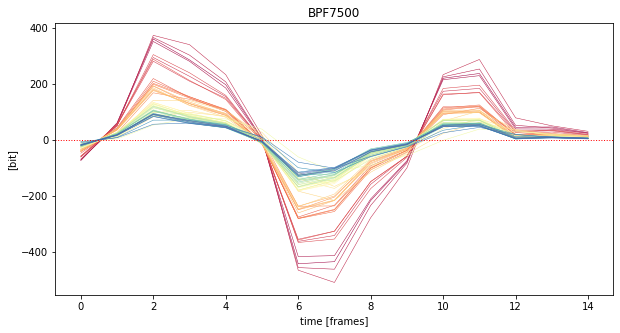

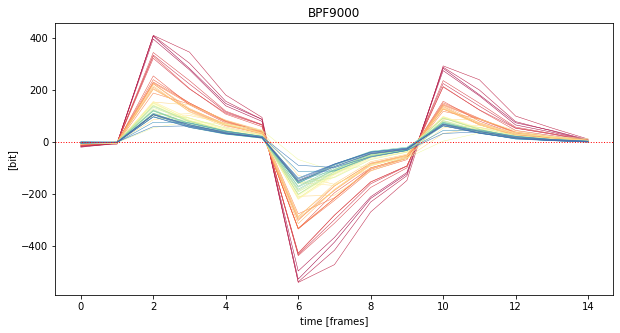

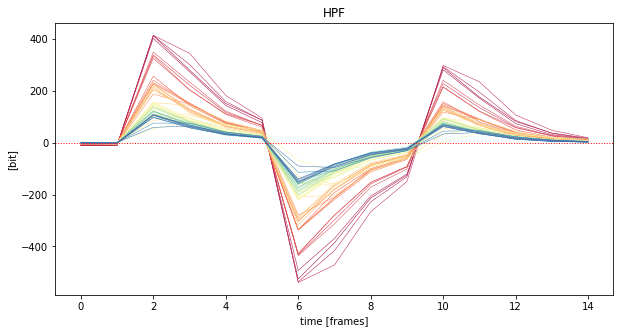

In [11]:
for name,bpf in bpfs.items():
    assay=assay_list['searching-9295-9515.raw.h5']
    assay.data_filtered_m=assay.filterProccessing(bpf,assay.data_raw_m, True)
    assay.data_filtered=assay.data_filtered_m[:, :, assay.BPF_MARGIN_FRAME:-assay.BPF_MARGIN_FRAME]
    assay.disp_filtered(trange=[1],yrange=None,xids=np.s_[:50], frange=np.s_[:15], title=name)

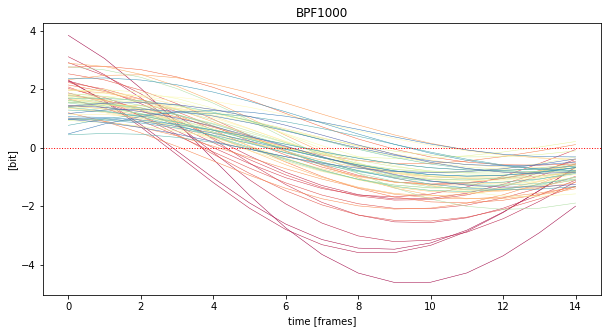

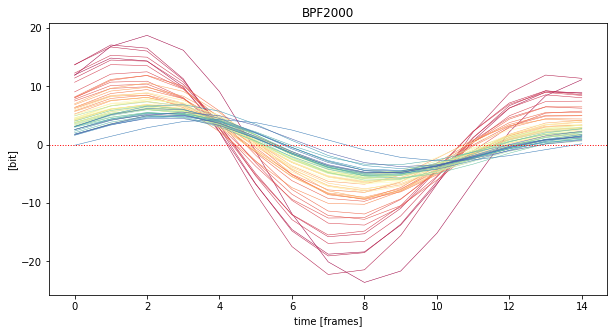

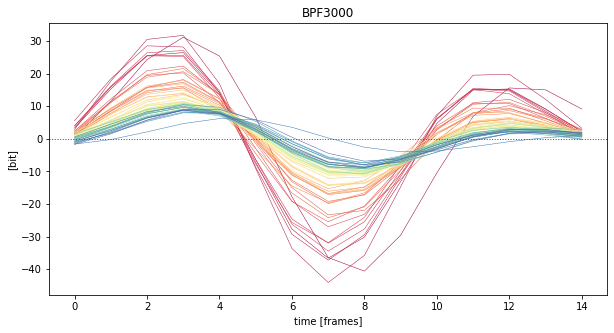

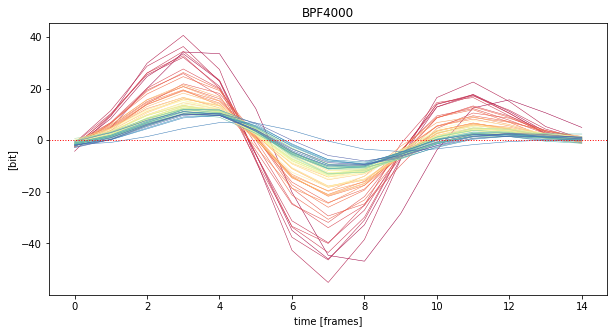

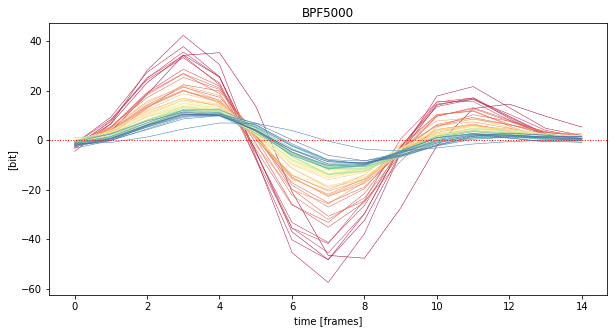

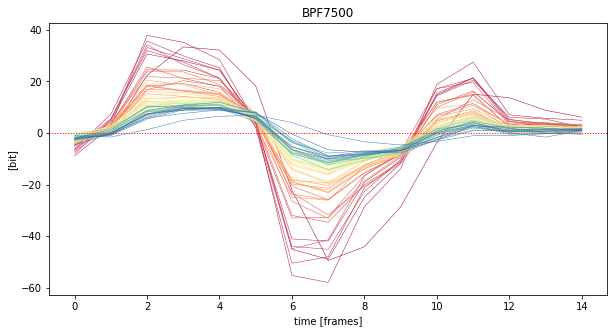

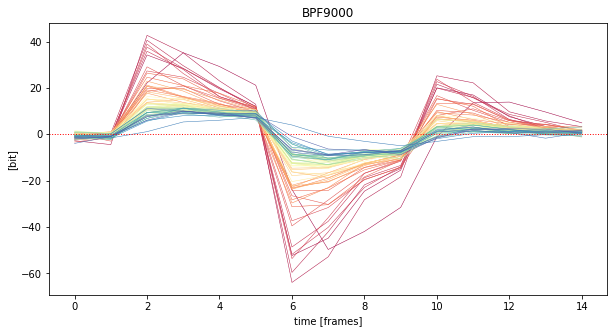

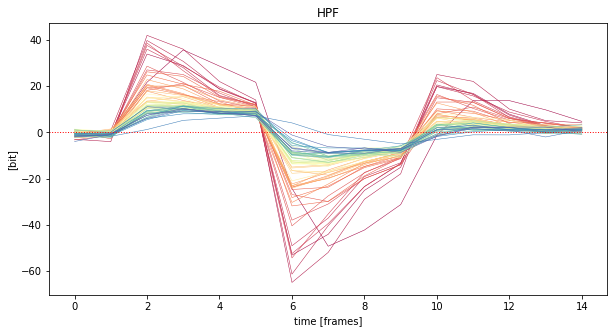

In [12]:

for name,bpf in bpfs.items():
    assay=assay_list['searching-9295-9515.raw.h5']
    assay.data_filtered_m=assay.filterProccessing(bpf,assay.data_raw_m, True)
    assay.data_filtered=assay.data_filtered_m[:, :, assay.BPF_MARGIN_FRAME:-assay.BPF_MARGIN_FRAME]
    assay.disp_filtered(trange=[1],yrange=None,xids=np.s_[100::10], frange=np.s_[:15], title=name)

### trial1回目は再現性がない

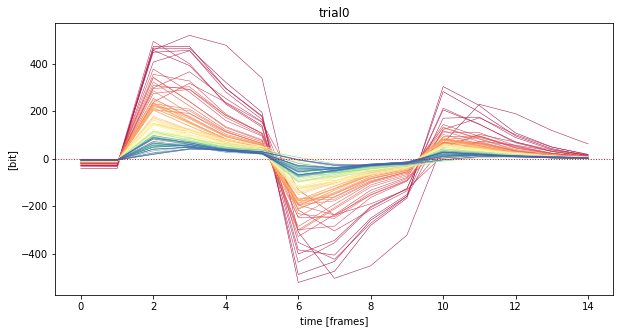

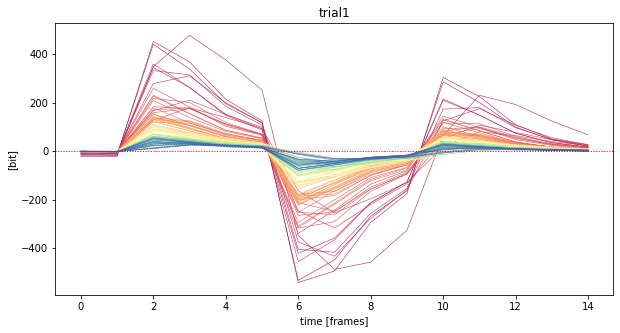

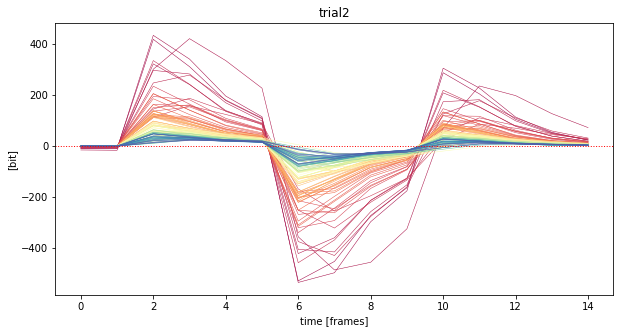

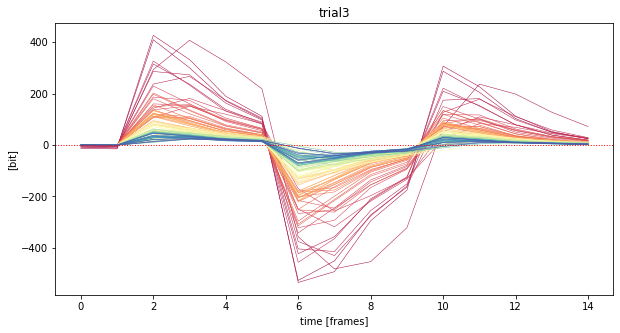

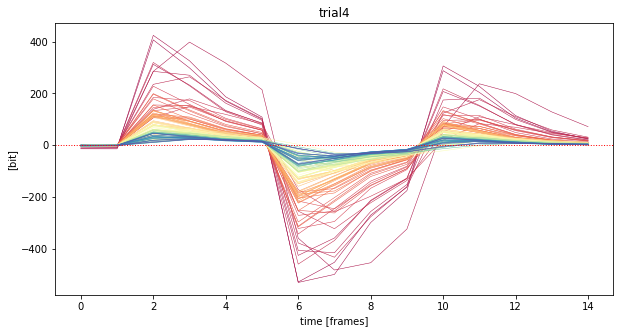

In [13]:
for i in range(5):
    assay=list(assay_list.values())[3]
    bpf=bpfs['HPF']
    assay.data_filtered_m=assay.filterProccessing(bpf,assay.data_raw_m, True)
    assay.data_filtered=assay.data_filtered_m[:, :, assay.BPF_MARGIN_FRAME:-assay.BPF_MARGIN_FRAME]
    assay.disp_filtered(trange=[i],yrange=None,xids=np.s_[0:100], frange=np.s_[:15], title='trial' + str(i))
    